In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import lsst.sims.movingObjects as mo

In [3]:
orbitfile = 'NESCv9reintv1.TCO.withH.kep.des'
mini = mo.Orbits()
mini.readOrbits(orbitfile)
mini.orbits.iloc[4407]

objId           NESC000096qI
a                    1.01108
e                  0.0124973
inc                 0.196962
Omega                 303.12
argPeri              87.1357
meanAnomaly          122.071
H                    36.9101
epoch                  55978
g                       0.15
sed_filename           S.dat
Name: 4407, dtype: object

In [4]:
pyo = mo.PyOrbEphemerides()
pyo.setOrbits(mini[0])

In [5]:
import lsst.sims.maf.db as db

In [6]:
opsdb = db.OpsimDatabase('kraken_2026.db')

In [7]:
opsdb.fetchPropInfo()

({1: 'GalacticPlane',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'NorthEclipticSpur',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [4]})

In [8]:
nightlimit = 365 * 5
simData = opsdb.fetchMetricData(['fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos', 
                                 'fiveSigmaDepth', 'filter', 'seeingFwhmGeom'], 
                                sqlconstraint='night < %d and proposalId = 3' % (nightlimit))

In [9]:
sortIdx = np.argsort(simData['observationStartMJD'])
simData = simData[sortIdx]

In [10]:
tstep = 1.0
times = np.arange(int(simData['observationStartMJD'][0]) + 0.56, 
                  int(simData['observationStartMJD'][-1]) + 0.56 + tstep, 
                  tstep)
print(len(times), times.min(), times.max())

1822 59853.56 61674.56


In [11]:
%%timeit
ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='2body', ephType='basic')

34.8 ms ± 822 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='nbody', ephType='basic')

256 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
pyo.setOrbits(mini[4407])
ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='nbody', ephType='basic')

In [16]:
(np.percentile(np.diff(ephs['ra']*np.cos(np.radians(ephs['dec']))), 99.8), 
 np.percentile(np.diff(ephs['ra']*np.cos(np.radians(ephs['dec']))), 99.9), )

(1.3941809437762411, 1.394978659603878)

In [17]:
np.diff(ephs['dec']).max()

0.39774691832826126

In [18]:
# Looks like minimoon typically travel few degrees per day (is there higher variation on shorter timescales?)

In [20]:
(256/100) * 20000 / 60. / 60. 

14.222222222222223

In [ ]:
# How many objects actually get bright enough that they might be seen by LSST? 
# (over specified time range of close approaches)
bright_objs = []
tstep = 2.0
times = np.arange(54466, 61771 + tstep/2., tstep)
pyo = mo.PyOrbEphemerides()
for i, obj in enumerate(mini):
    pyo.setOrbits(obj)
    ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='nbody')
    if (ephs[0]['magV'].min() < 26.5):
        bright_objs.append(i)

In [ ]:
len(mini), len(bright_objs)

In [ ]:
br = mini[bright_objs]

In [ ]:
br.orbits.to_csv('all_bright_NESCv9reintv1.TCO.withH.kep.des', index=False, sep=' ')

In [45]:
br = mo.Orbits()
br.readOrbits('all_bright_NESCv9reintv1.TCO.withH.kep.des')

Text(0,0.5,'Number of objects')

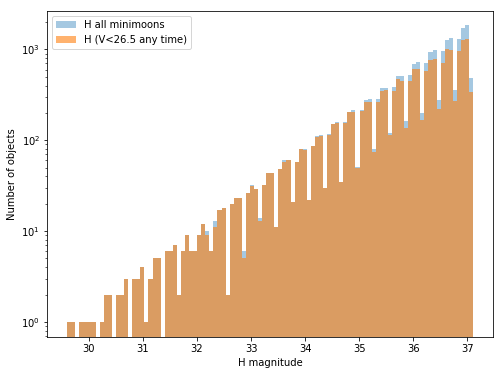

In [48]:
plt.figure(figsize=(8, 6))
n, b, p = plt.hist(mini.orbits.H, bins=100, alpha=0.4, label='H all minimoons')
n, b, p = plt.hist(br.orbits.H, bins=b, alpha=0.6, label='H (V<26.5 any time)')
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.semilogy()
plt.xlabel('H magnitude')
plt.ylabel('Number of objects')

Text(0,0.5,'Number of objects')

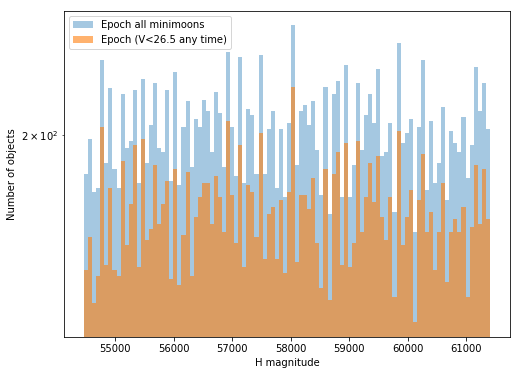

In [49]:
plt.figure(figsize=(8, 6))
n, b, p = plt.hist(mini.orbits.epoch, bins=100, alpha=0.4, label='Epoch all minimoons')
n, b, p = plt.hist(br.orbits.epoch, bins=b, alpha=0.6, label='Epoch (V<26.5 any time)')
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.semilogy()
plt.xlabel('H magnitude')
plt.ylabel('Number of objects')

In [30]:
# What about time of overlap with LSST? (start of LSST obs, to end of LSST)
bright_objs = []
tstep = 1.0
times = np.arange(int(simData['observationStartMJD'][0]) + 0.56, 
                  int(simData['observationStartMJD'][-1]) + 0.56 + tstep, 
                  tstep)
pyo = mo.PyOrbEphemerides()
for i, obj in enumerate(mini):
    pyo.setOrbits(obj)
    ephs = pyo.generateEphemerides(times, timeScale='TAI', obscode='I11', ephMode='nbody')
    if (ephs[0]['magV'].min() < 26.5):
        bright_objs.append(i)

In [31]:
print(len(mini), len(bright_objs))
br = mini[bright_objs]
br.orbits.to_csv('lsst_bright_NESCv9reintv1.TCO.withH.kep.des', index=False, sep=' ')

20265 4557


In [33]:
simData['observationStartMJD'].min(), simData['observationStartMJD'].max()

(59853.016793981478, 61674.162268518521)

In [42]:
br = mo.Orbits()
br.readOrbits('lsst_bright_NESCv9reintv1.TCO.withH.kep.des')

Text(0,0.5,'Number of objects')

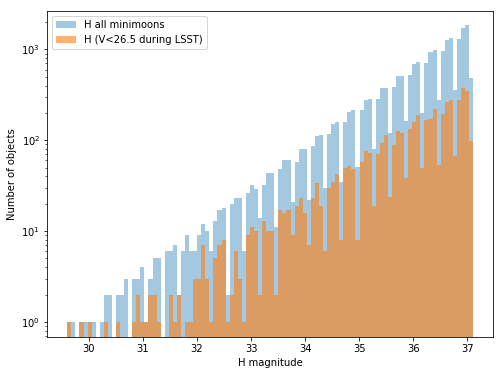

In [43]:
plt.figure(figsize=(8, 6))
n, b, p = plt.hist(mini.orbits.H, bins=100, alpha=0.4, label='H all minimoons')
n, b, p = plt.hist(br.orbits.H, bins=b, alpha=0.6, label='H (V<26.5 during LSST)')
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.semilogy()
plt.xlabel('H magnitude')
plt.ylabel('Number of objects')

Text(0,0.5,'Number of objects')

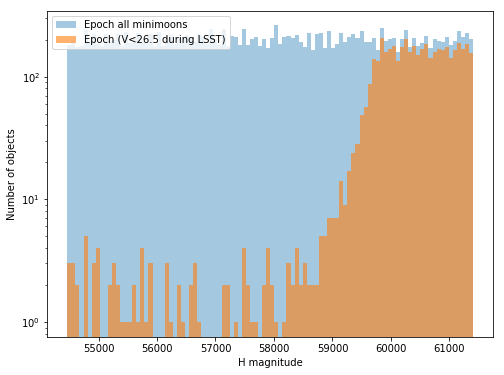

In [44]:
plt.figure(figsize=(8, 6))
n, b, p = plt.hist(mini.orbits.epoch, bins=100, alpha=0.4, label='Epoch all minimoons')
n, b, p = plt.hist(br.orbits.epoch, bins=b, alpha=0.6, label='Epoch (V<26.5 during LSST)')
plt.legend(loc='upper left', fancybox=True, numpoints=1)
plt.semilogy()
plt.xlabel('H magnitude')
plt.ylabel('Number of objects')